# Demonstrating how to access AWS telemetry data stored in DyanmoDB     

## Data Ingestion

### Get from AWS

In [1]:
import boto3
from boto3.dynamodb.conditions import Key

dyanmodb = boto3.resource('dynamodb', region_name="us-east-2")
telemetry_table = dyanmodb.Table('telemetry')

In [2]:
import pandas as pd

data = telemetry_table.query(
    KeyConditionExpression=Key('test_id').eq('nokia-jun-4')
)['Items']

failed = 0
parsed_data = []
for row in data:
    try:
        
        messages = row['messages'].split('|')
        
        for message in messages:
            split = message.split(',')
            
            try:
                parsed_data.append(
                    {
                        'aws_timestamp': row['timestamp'],
                        'test_id': row['test_id'],
                        'timestamp': split[0],
                        'throttle': int(split[1]),
                        'speed': int(split[2]),
                        'rpm': int(split[3]),
                        'current': int(split[4]),
                        'voltage': int(split[5]),
                        'throttleTooHigh': int(split[6]),
                        'motorInitializing': int(split[7]),
                        'clockState': int(split[8]),
                        'lastDeadman': split[9]
                    }
                )
            except:
                # print(f"Failed to parse message chunk: {split}")
                failed += 1
    except:
        print(f"Failed to parse {row['test_id']} message with timestamp: {row['timestamp']}.")


telemetry_data = pd.DataFrame(parsed_data)
print(f"Failed to parse {failed} out of {telemetry_data.size + failed} messages")

telemetry_data.head()

Failed to parse 86 out of 65054 messages


,aws_timestamp,test_id,timestamp,throttle,speed,rpm,current,voltage,throttleTooHigh,motorInitializing,clockState,lastDeadman
0,2023-06-04 13:37:37.897,nokia-jun-4,00.00.32,0,0,0,0,3628,0,0,0,00.00.00
1,2023-06-04 13:37:37.897,nokia-jun-4,00.00.32,0,0,0,0,4034,0,0,0,00.00.00
2,2023-06-04 13:37:37.897,nokia-jun-4,00.00.32,0,0,0,0,3639,0,0,0,00.00.00
3,2023-06-04 13:37:37.897,nokia-jun-4,00.00.32,0,0,0,0,3628,0,0,0,00.00.00
4,2023-06-04 13:37:37.897,nokia-jun-4,00.00.32,0,0,0,0,3621,0,0,0,00.00.00


### Processing Data

In [3]:
from typing import List
from Telemetry import TelemetryProcessor, TelemetryDataPoint, InstantEfficiencyDataPoint
from datetime import datetime, timedelta

def codeToVoltage(x):
    return 0.02048 * x + -0.53823

def codeToAmps(x):
    return (0.01082 * x + -20.17682) * 2

processed: List[TelemetryDataPoint] = []

for i, row in telemetry_data.iterrows():
    processed.append(
        TelemetryDataPoint(
            timestamp=datetime.strptime(row['timestamp'], '%H.%M.%S'),
            speed=float(row['speed']) / 1000, # m/h -> km/h
            voltage=codeToVoltage(row['voltage']),
            current=codeToAmps(row['current']),
            rpm=int(row['rpm']) * -1
        )
    )

currentCodes = telemetry_data.current.tolist()
voltageCodes = telemetry_data.voltage.tolist()

instantEfficiencyDataPoints = TelemetryProcessor.get_inst_efficiency(processed, 10)

ValueError: time data '0.36' does not match format '%H.%M.%S'

## Graphing Data

### RPM, Speed and Current over time

/var/folders/tw/qm7nc9kd0j91hj74kmf3hk0r0000gn/T/ipykernel_85764/1346676097.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


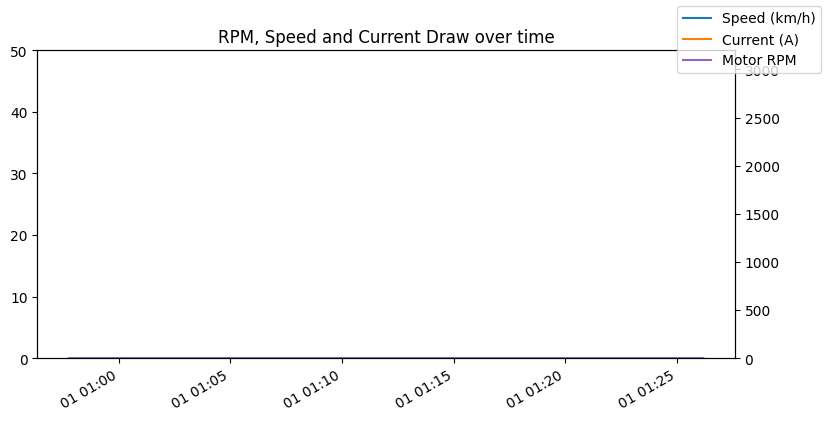

In [ ]:
import matplotlib.pyplot as plt
timestamps = [point.timestamp for point in processed]
speeds = [point.speed / 1000 for point in processed]
currents = [point.current for point in processed]
voltages = [point.voltage for point in processed]
rpms = [abs(point.rpm) for point in processed]
joules = [point.current * point.voltage for point in processed]

fig, leftAx = plt.subplots()
fig.set_size_inches(9,4)
leftAx.set_title("RPM, Speed and Current Draw over time")
leftAx.set_ylim(0, 50)

rightAx = leftAx.twinx()
rightAx.set_ylim(0, 3200)

rpmLine = rightAx.plot(timestamps, rpms, color='tab:purple', label='Motor RPM')
speedLine = leftAx.plot(timestamps, speeds, label='Speed (km/h)')
currentLine = leftAx.plot(timestamps, currents, color='tab:orange', label='Current (A)')

fig.legend(loc='upper right')

for label in leftAx.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

leftAx.grid(False)
rightAx.grid(False)

fig.show()

### Instant Efficiency over Time

[InstantEfficiencyDataPoint(timestamp=datetime.datetime(1900, 1, 1, 0, 57, 46), instant_efficiency=0.0), InstantEfficiencyDataPoint(timestamp=datetime.datetime(1900, 1, 1, 0, 57, 47), instant_efficiency=0.0), InstantEfficiencyDataPoint(timestamp=datetime.datetime(1900, 1, 1, 0, 57, 48), instant_efficiency=-0.0), InstantEfficiencyDataPoint(timestamp=datetime.datetime(1900, 1, 1, 0, 57, 49), instant_efficiency=-0.0), InstantEfficiencyDataPoint(timestamp=datetime.datetime(1900, 1, 1, 0, 57, 50), instant_efficiency=-0.0), InstantEfficiencyDataPoint(timestamp=datetime.datetime(1900, 1, 1, 0, 57, 52), instant_efficiency=0.0), InstantEfficiencyDataPoint(timestamp=datetime.datetime(1900, 1, 1, 0, 57, 53), instant_efficiency=0.0), InstantEfficiencyDataPoint(timestamp=datetime.datetime(1900, 1, 1, 0, 57, 54), instant_efficiency=0.0), InstantEfficiencyDataPoint(timestamp=datetime.datetime(1900, 1, 1, 0, 57, 55), instant_efficiency=-0.0), InstantEfficiencyDataPoint(timestamp=datetime.datetime(1900

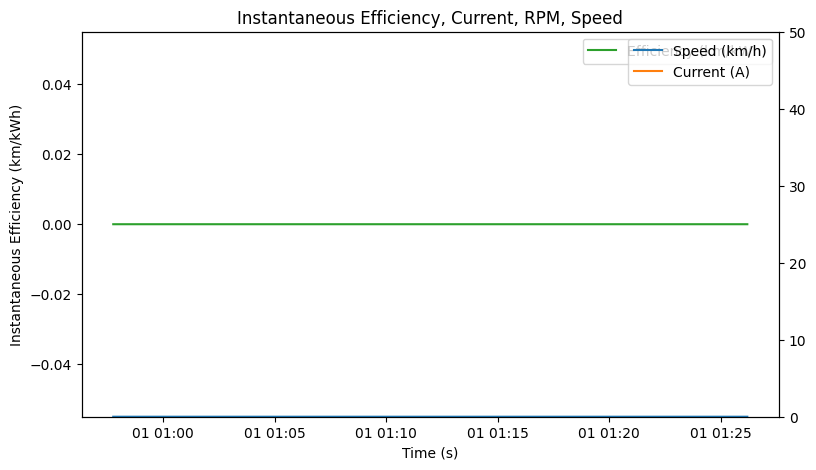

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime

timestamps = [point.timestamp for point in processed]
speeds = [point.speed / 1000 for point in processed]
currents = [point.current for point in processed]
rpms = [abs(point.rpm) for point in processed]
joules = [point.current * point.voltage for point in processed]

fig, leftAx = plt.subplots()
rightAx = leftAx.twinx()
fig.set_size_inches(9,5)

rightAx.plot(timestamps, speeds, "-", label="Speed (km/h)")
rightAx.plot(timestamps, currents, "-", label="Current (A)")

leftAx.set_title("Instantaneous Efficiency, Current, RPM, Speed")
leftAx.set_xlabel("Time (s)")
leftAx.set_ylabel("Instantaneous Efficiency (km/kWh)")

rightAx.set_ylim(0, 50)


print(instantEfficiencyDataPoints)
leftAx.plot(
    [point.timestamp for point in instantEfficiencyDataPoints],
    [point.instant_efficiency for point in instantEfficiencyDataPoints],
    label="Efficiency (km/kWh)",
    color='tab:green'
)

leftAx.legend()
rightAx.legend()

### Battery voltage over time

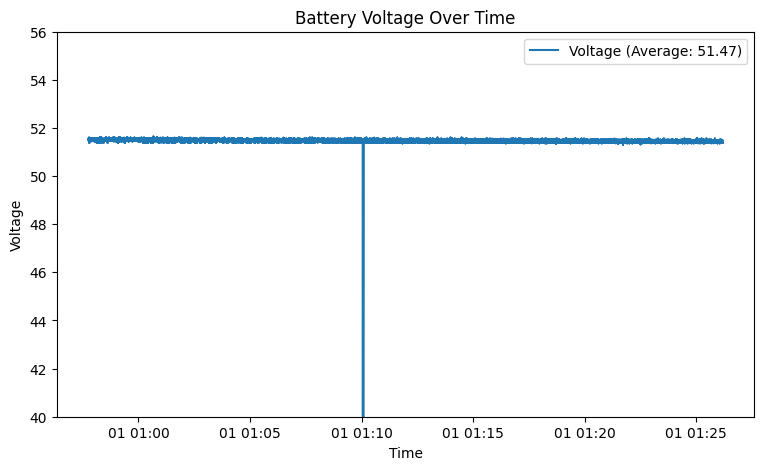

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(9,5)

ax.set_ylim(40, 56)

ax.set_title("Battery Voltage Over Time")
ax.set_ylabel("Voltage")
ax.set_xlabel("Time")

ax.plot(timestamps, voltages, label="Voltage")
legend = ['Voltage (Average: %.2f)' %(sum(voltages) / len(voltages))]
ax.legend(legend)

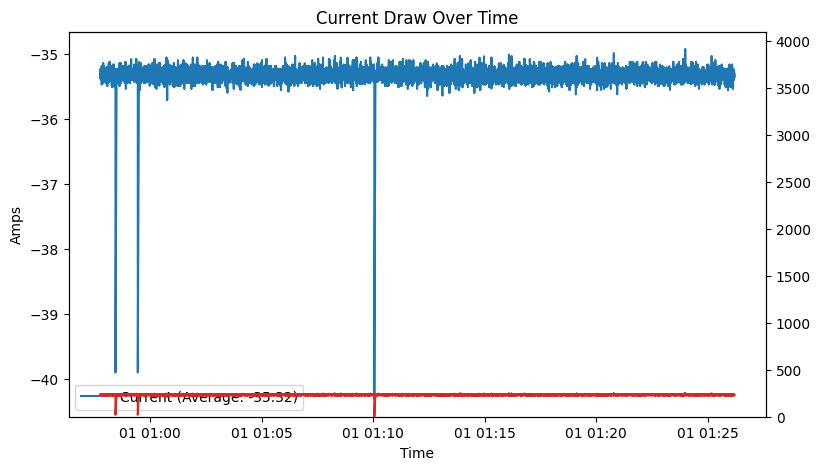

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(9,5)

ax.set_title("Current Draw Over Time")
ax.set_ylabel("Amps")
ax.set_xlabel("Time")

ax.plot(timestamps, currents)

ax1 = ax.twinx()
ax1.plot(timestamps, currentCodes, color='tab:red')
ax1.set_ylim(0, 4096)

legend = ['Current (Average: %.2f)' %(sum(currents) / len(currents))]

ax.legend(legend)